In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata

from dredFISH.Design import PNMF
from dredFISH.Analysis import basicu

import importlib
importlib.reload(PNMF)

<module 'dredFISH.Design.PNMF' from '/bigstore/GeneralStorage/fangming/projects/dredfish/packages/dredFISH/dredFISH/Design/PNMF.py'>

In [2]:
prj_dir = '/bigstore/GeneralStorage/fangming/projects/dredfish/'
dat_dir = prj_dir + 'data/'
res_dir = prj_dir + 'data_dump/'
fig_dir = prj_dir + 'figures/'

# data
scrna_genes_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_DPNMF_genes_matrix.h5ad'

In [3]:
%%time
# allen scrna matrix
adata = anndata.read_h5ad(scrna_genes_path) # library size normed (no log)
adata

CPU times: user 566 ms, sys: 1.02 s, total: 1.58 s
Wall time: 1.58 s


AnnData object with n_obs × n_vars = 73347 × 5576
    obs: 'donor_sex_id', 'donor_sex_label', 'donor_sex_color', 'region_id', 'region_label', 'region_color', 'platform_label', 'cluster_order', 'cluster_label', 'cluster_color', 'subclass_order', 'subclass_label', 'subclass_color', 'neighborhood_id', 'neighborhood_label', 'neighborhood_color', 'class_order', 'class_label', 'class_color', 'exp_component_name', 'external_donor_name_label', 'full_genotype_label', 'facs_population_plan_label', 'injection_roi_label', 'injection_materials_label', 'injection_method_label', 'injection_type_label', 'full_genotype_id', 'full_genotype_color', 'external_donor_name_id', 'external_donor_name_color', 'facs_population_plan_id', 'facs_population_plan_color', 'injection_materials_id', 'injection_materials_color', 'injection_method_id', 'injection_method_color', 'injection_roi_id', 'injection_roi_color', 'injection_type_id', 'injection_type_color', 'cell_type_accession_label', 'cell_type_alias_label', 'cel

In [4]:
%%time
#log trans
X = np.array(adata.X.todense()).copy() # already library size normalized
logX = np.log10(X+1)

CPU times: user 7.55 s, sys: 2.49 s, total: 10 s
Wall time: 10 s


In [5]:
%%time
# run PNMF logtrans -- recommended by them
w, rec = PNMF.get_PNMF(logX.T, k=4, verbose=True, report_stride=1)

1 0.998707354839329
2 0.024898809655484522
3 0.00699248705079919
4 0.0020816975029345347
5 0.0005998752740771253
6 0.00016871930937444133
7 4.953383783928931e-05
8 1.798052749858725e-05
9 9.939176117395503e-06
CPU times: user 2min 3s, sys: 2.91 s, total: 2min 6s
Wall time: 11 s


In [17]:
%%time
# run PNMF orig -- what we do and have to do
w2, rec2 = PNMF.get_PNMF(X.T, k=4, verbose=True, report_stride=10)

10 0.00016040604192691169
20 0.00013644371044176096
30 0.0001056764095618036
40 8.667134195464513e-05
50 7.352683739272284e-05
60 6.190994273059473e-05
70 5.131183540069335e-05
80 4.059135981341125e-05
90 2.9906339338808688e-05
100 2.239612271362837e-05
110 1.723712381718201e-05
120 1.342824344521148e-05
130 1.055511331293107e-05
CPU times: user 5min 46s, sys: 19.6 s, total: 6min 6s
Wall time: 26 s


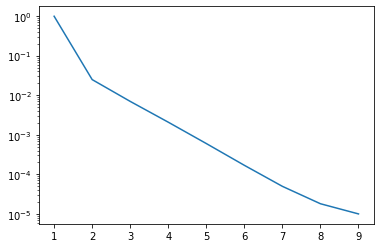

In [7]:
plt.plot(rec[:,0], rec[:,1])
plt.yscale('log')

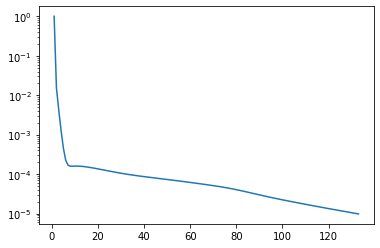

In [8]:
plt.plot(rec2[:,0], rec2[:,1])
plt.yscale('log')

In [9]:
np.linalg.norm(w, 2), np.max(w), np.min(w)

(0.99999994, 0.037506573, 0.0)

In [10]:
np.linalg.norm(w2, 2), np.max(w2), np.min(w2)

(1.0, 0.47854725, 0.0)

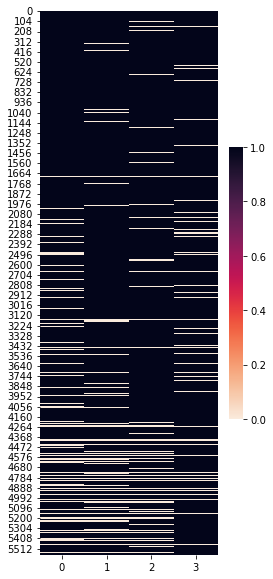

In [11]:
wnew, rows, cols = basicu.diag_matrix_rows(w)

fig, ax = plt.subplots(figsize=(4,10))
sns.heatmap(wnew>(1.0/120)*np.max(wnew), 
            ax=ax, 
            cmap='rocket_r', 
            cbar_kws=dict(shrink=0.5),
           )
plt.show()

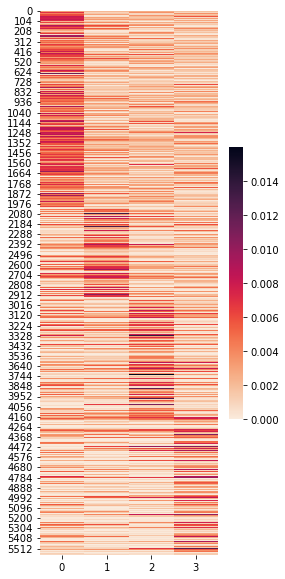

In [12]:
wnew, rows, cols = basicu.diag_matrix_rows(w)

fig, ax = plt.subplots(figsize=(4,10))
sns.heatmap(np.log10(wnew+1), 
            ax=ax, 
            cmap='rocket_r', 
            cbar_kws=dict(shrink=0.5),
           )
plt.show()

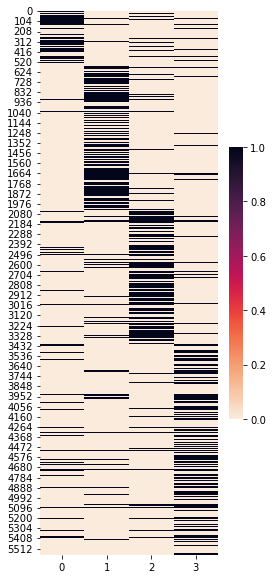

In [13]:
w2new, rows, cols = basicu.diag_matrix_rows(w2)

fig, ax = plt.subplots(figsize=(4,10))
sns.heatmap(w2new>1.0/120*np.max(w2new), 
            ax=ax, 
            cmap='rocket_r', 
            cbar_kws=dict(shrink=0.5),
           )
plt.show()

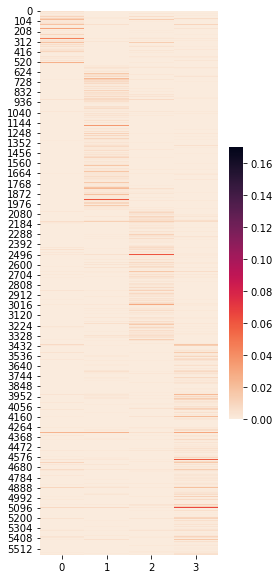

In [14]:
w2new, rows, cols = basicu.diag_matrix_rows(w2)

fig, ax = plt.subplots(figsize=(4,10))
sns.heatmap(np.log10(w2new+1), 
            ax=ax, 
            cmap='rocket_r', 
            cbar_kws=dict(shrink=0.5),
           )
plt.show()

# plot distribution

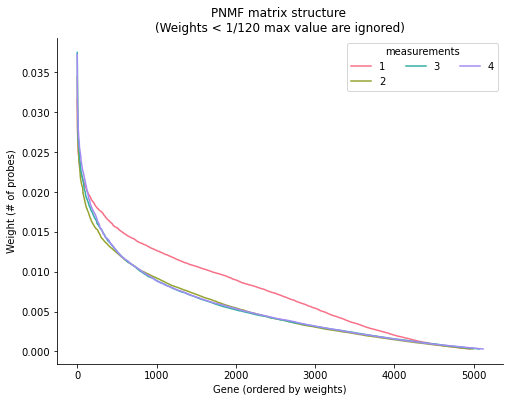

In [15]:
pm = sns.color_palette('husl', n_colors=4)
pmat = pd.DataFrame(w)
cutoff = 1/120*np.max(pmat.values)

fig, ax = plt.subplots(figsize=(8,6))
for i, col in enumerate(pmat):
    _x = pmat[col]
    _x = np.flip(np.sort(_x[_x>0])) #[:,:,-1]
    _x = _x[_x > cutoff]
    ax.plot(_x, color=pm[i], label=f'{i+1}')
ax.set_xlabel('Gene (ordered by weights)')
ax.set_ylabel('Weight (# of probes)')
sns.despine(ax=ax)
ax.set_title('PNMF matrix structure \n(Weights < 1/120 max value are ignored)')
ax.legend(ncol=3, title='measurements')

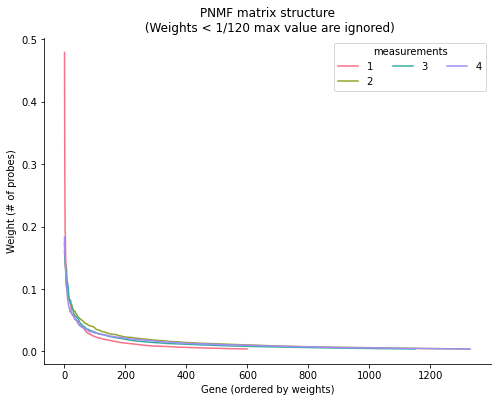

In [16]:
pm = sns.color_palette('husl', n_colors=4)
pmat = pd.DataFrame(w2)
cutoff = 1/120*np.max(pmat.values)

fig, ax = plt.subplots(figsize=(8,6))
for i, col in enumerate(pmat):
    _x = pmat[col]
    _x = np.flip(np.sort(_x[_x>0])) #[:,:,-1]
    _x = _x[_x > cutoff]
    ax.plot(_x, color=pm[i], label=f'{i+1}')
ax.set_xlabel('Gene (ordered by weights)')
ax.set_ylabel('Weight (# of probes)')
sns.despine(ax=ax)
ax.set_title('PNMF matrix structure\n (Weights < 1/120 max value are ignored)')
ax.legend(ncol=3, title='measurements')